## Import libraries

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.integrate import simpson

## Important functions for calculations

### Trigonometry functions in degree

In [2]:
def sind(t):
    return math.sin(math.radians(t))
def cosd(t):
    return math.cos(math.radians(t))
def tand(t):
    return math.tan(math.radians(t))
def asind(t):
    return math.degrees(math.asin(t))
def acosd(t):
    return math.degrees(math.acos(t))
def atand(t):
    return math.degrees(math.atan(t))

### Interpolation function

In [3]:
def interpolate(x,y):
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(min(x), max(x), 500)
    Y_ = X_Y_Spline(X_)
    return X_,Y_

In [4]:
# Declitaion angle
def decl(n):
    de = 23.45*sind((360*(284+n))/365)
    return de
# Hour angle
def ha(st):
    return 15*(12-st)

#Theta
def theta(beta , delta , gamma , omega , phi):
    ca = sind(phi)*(sind(delta)*cosd(beta)+cosd(delta)*cosd(gamma)*cosd(omega)*sind(beta)) + cosd(phi)*(cosd(delta)*cosd(omega)*cosd(beta)-sind(delta)*cosd(gamma)*sind(beta)) + cosd(delta)*sind(gamma)*sind(omega)*sind(beta)
    return acosd(ca)

#Theta Z
def theta_z(delta , gamma , omega , phi):
    return theta(0, delta , gamma ,omega ,phi)

#Tilt factor beam
def rb(n, st , beta ,gamma, phi):
    ca = cosd(theta(beta, decl(n), gamma, ha(st),phi))
    caz = cosd(theta_z(decl(n), gamma, ha(st),phi))
    rb = ca/caz
    return rb

#Tilt factor diffuse
def rd(beta):
    return 0.5*(1+cosd(beta))

#Tilt factor reflected
def rr(beta, rohg):
    return (rohg/2)*(1-cosd(beta))

#Theta dash
def thetadash(ng , na , theta):
    return asind(sind(theta)*(na/ng))

#Total solar radiation flux
def I_total(Ibh,Idh , rb , rd , rr):
    return (Ibh*rb + Idh*rd + (Ibh+Idh)*rr)

def roh1(theta , thetad):
    return pow(sind(thetad-theta),2)/pow(sind(thetad+theta),2)
def roh2(theta , thetad):
    return pow(tand(thetad-theta),2)/pow(tand(thetad+theta),2)
def tau1(roh1 , m):
    return (1-roh1)/(1+roh1*(2*m-1))
def tau2(roh2 , m):
    return (1-roh2)/(1+roh2*(2*m-1))
def tau_a(theta_d,k,delC):
    return math.exp(-(k*delC)/cosd(theta_d))
def alpha(theta):
    if theta-85 > 5:
        return 0
    up = 0.0106944*(theta-90)*(1-0.254*pow((cosd(theta)/cosd(85)),4*(theta-85)))
    down = pow((theta/95.406),0.9775)-1
    if type(up/down) == complex:
        return 0
    else:
        return up/down
def tau_alp_b(tau,alpha,roh_d):
    return (tau*alpha)/(1-(1-alpha)*roh_d)
def tau_alp_d(theta ,ng,na,m,k,delC,roh_d):
    td = thetadash(ng,na,theta)
    roh_1 = roh1(theta,td)
    roh_2 = roh2(theta,td)
    tau_1 =  tau1(roh_1,m)
    tau_2 =  tau2(roh_2,m)
    taua = tau_a(td,k,delC)
    alp = alpha(theta)
    return tau_alp_b((taua*0.5*(tau_1+tau_2)),alp,roh_d)
def S(Ibh, Idh, rb, rd, rr, tau_b , tau_d):
    return (Ibh*rb*tau_b + (Idh*rd+(Ibh+Idh)*rr)*tau_d)
def fin_eff(U,K,cpst,L):
    m = pow((U/(K*cpst)),0.5)
    return ((math.exp(m*L)-math.exp(-m*L))/(math.exp(m*L)+math.exp(-m*L)))/(m*L)
def collector_eff(U,W,L,F,Do,cb,Di,hci):
    up = 1/U
    down1 = 1/(U*(2*L*F+Do))
    down2 = 1/cb
    down3 = 1/(hci*math.pi*Di)
    return up/(W*(down1+down2+down3))
def hear_removal_factor(mw,cw,U,fd):
    return (mw*cw/U)*(1-math.exp((-U*fd)/(mw*cw)))

In [5]:
st = [6,7,8,9,10,11,12,13,14,15,16,17,18]
st_t = [6,7,8,9,10,11,12,13,14,15,16,17,18,'Daily']
I = [
    [[0,0,147,300,426,509,537,509,426,300,147,0,0],[0,0,56,77,91,98,98,98,91,77,56,0,0]],
    [[0,42,216,391,502,593,621,593,502,391,216,42,0],[0,25,70,91,98,105,105,105,98,91,70,28,0]],
    [[0,105,293,453,593,649,712,649,593,453,293,105,0],[0,49,84,98,105,105,105,105,105,98,84,49,0]],
    [[0,160,356,523,663,747,767,747,663,523,356,160,0],[0,70,91,98,105,112,112,112,105,98,91,70,0]],
    [[42,209,398,565,705,788,816,788,705,565,398,209,42],[42,77,98,105,105,112,112,112,105,105,98,77,42]],
    [[63,230,412,586,705,788,816,788,705,586,412,230,63],[49,77,98,105,112,112,112,112,112,105,98,77,49]],
    [[56,223,405,565,684,767,795,767,684,565,405,223,56],[42,77,98,105,105,112,112,112,105,105,98,77,42]],
    [[28,188,363,530,670,753,781,753,670,530,363,188,28],[35,70,91,105,105,112,112,112,105,105,91,70,35]],
    [[0,119,307,474,607,698,726,698,607,474,307,119,0],[0,63,84,98,105,105,112,105,105,98,84,63,0]],
    [[0,49,223,384,516,593,628,593,516,384,223,49,0],[0,35,77,91,98,105,105,105,98,91,77,35,0]],
    [[0,0,147,300,419,495,523,495,419,300,147,0,0],[0,0,63,84,91,98,98,98,91,84,63,0,0]],
    [[0,0,112,265,391,460,495,460,391,265,112,0,0],[0,0,49,77,91,98,98,98,91,77,49,0,0]]
]

Twi = [14.8, 16.1, 19.4, 22.7, 24.3, 27.5, 28.5, 29.3, 27.9, 26, 21.4, 17.6]
Ta_r = [
    [8.8, 19.7],
    [9.8, 21.2],
    [11.9, 24.4],
    [14.8, 28.5],
    [17.5, 32.2],
    [20.7, 34.9],
    [22, 34.7],
    [22.3, 34.5],
    [20.6, 33.1],
    [18.1, 30.6],
    [14, 25.5],
    [10.3, 21.1]   
]
DR = [98,93,84,71,56,39,23,11,3,0,3,10,21]
avg_d = [17,47,75,105,135,162,198,228,258,288,318,334]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [6]:
srs = []
sss = []
for i in range(12):
        ws = -acosd(-tand(30)*tand(decl(30*i+15)))
        sr = round(12+ws/15,2)
        ss = round(12-(ws/15),2)
        srs.append(sr)
        sss.append(ss)        

In [ ]:
gamma = 20
beta = 40
phi = 30
n_o_c = 1
k = 0.0068
ng = 1.526
na = 1
delC = 4
roh_g = 0.2
U = 5
K = 385
cpst = 0.5/1000
Do= 11/1000
Di= 10/1000
cb = 35
W = 150/1000
mw = 0.015
cw = 4180
hci = 300
twh=55
vw = 220
Twh=55
thta_diff = 20
if n_o_c == 1 :
    roh_d = 0.15
elif n_o_c == 2:
    roh_d = 0.22
elif n_o_c == 3: 
    roh_d = 0.24

# Working on average days

In [ ]:
def iqs_4m(m,gamma):
    gamma = gamma
    n = avg_d[m-1]
    I_total_m = []
    S_m = []
    Q_m = []
    Ac_m =[]
    NOT_m =[]
    Eff_m =[]
    for i in range(10):
        beta = 10*i
        theta_in = []
        theta_z_in = []
        rb_in = []
        I_total_in = []
        thetadash_in = []
        roh1_in = []
        roh2_in = []
        tau1_in = []
        tau2_in = []
        tau_r = []
        tau_a_in = []
        tau = []
        alpha_in = []
        tau_a_b_in = []
        S_in = []
        qu = []

        # DIFFUSE
        rd_in = rd(beta)
        rr_in = rr(beta, roh_g)
        tau_a_d_in = tau_alp_d(thta_diff, ng, na, n_o_c, k, delC, roh_d)

        # TANK
        L = (W-Do)/2
        F = fin_eff(U,K,cpst,L)
        F_d = collector_eff(U,W,L,F,Do,cb,Di,hci)
        FR = hear_removal_factor(mw,cw,U,F_d)
        for i in range(len(st)):
            theta_in.append(theta(beta,decl(n),gamma,ha(st[i]),phi))
            theta_z_in.append(theta_z(decl(n),gamma,ha(st[i]),phi))
            if rb(n,st[i],beta ,gamma, phi) < 0:
                rb_in.append(0)
            else:
                rb_in.append(rb(n,st[i],beta ,gamma, phi))
            I_total_in.append(I_total(I[m-1][0][i],I[m-1][1][i],rb_in[i],rd(beta),rr(beta,0.2)))
            thetadash_in.append(thetadash(ng,na,theta_in[i]))
            roh1_in.append(roh1(theta_in[i],thetadash_in[i]))
            roh2_in.append(roh2(theta_in[i],thetadash_in[i]))
            tau1_in.append(tau1(roh1_in[i],n_o_c))
            tau2_in.append(tau1(roh2_in[i],n_o_c))
            tau_r.append((tau1_in[i]+tau2_in[i])*0.5)
            tau_a_in.append(tau_a(thetadash_in[i],k,delC))
            tau.append(tau_a_in[i]*tau_r[i])  
            alpha_in.append(alpha(theta_in[i]))
            tau_a_b_in.append(tau_alp_b(tau[i],alpha_in[i],roh_d))
            S_in.append(S(I[m-1][0][i],I[m-1][1][i],rb_in[i], rd_in, rr_in, tau_a_b_in[i], tau_a_d_in))
        ta = Ta_r[m-1][1] - DR[0]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
        tw_n = [Twi[m-1]]
        if FR*(S_in[0]-U*(Twi[m-1]-ta)) < 0 :
            qu.append(0)
        else:
            qu.append(FR*(S_in[0]-U*(Twi[m-1]-ta)))

        for i in range(1,len(st)): 
            two = tw_n[i-1]+(qu[i-1]/(mw*cw))
            tw_n.append((two+tw_n[i-1])/2)
            ta = Ta_r[m-1][1] - DR[i]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
            if FR*(S_in[i]-U*(tw_n[i]-ta)) > 0: 
                qu.append(FR*(S_in[i]-U*(tw_n[i]-ta)))
            else:
                qu.append(0)
        I_total_daily = sum(I_total_in[1:len(I_total_in)])*(3600/pow(10,6))
        S_daily = sum(S_in[1:len(S_in)])*(3600/pow(10,6))
        Q_daily = sum(qu[1:len(qu)])*(3600/pow(10,6))
        I_total_in.append(I_total_daily)
        S_in.append(S_daily)
        qu.append(Q_daily)
        Ac = (vw*cw*(Twh-Twi[m-1]))/(Q_daily*pow(10,6))
        Ac_m.append(Ac)
        NOT_m.append(int((Ac/2)/W))
        Eff_m.append(Q_daily/I_total_daily)
        I_total_m.append(I_total_in)
        S_m.append(S_in)
        Q_m.append(qu)
    return I_total_m,S_m,Q_m,Ac_m,NOT_m,Eff_m

In [ ]:
full_data = []
for x in range(12):
    gamma_l = 0
    I_total_m = iqs_4m(x+1,gamma_l)[0]
    S_m = iqs_4m(x+1,gamma_l)[1]
    Q_m = iqs_4m(x+1,gamma_l)[2]
    Ac_m = iqs_4m(x+1,gamma_l)[3]
    NOT_m = iqs_4m(x+1,gamma_l)[4]
    Eff_m = iqs_4m(x+1,gamma_l)[5]
    I_avg = pd.DataFrame(data= {
    "ST":st_t,
    "Beta = 0" : I_total_m[0],
    "Beta = 10" : I_total_m[1],
    "Beta = 20" : I_total_m[2],
    "Beta = 30" : I_total_m[3],
    "Beta = 40" : I_total_m[4],
    "Beta = 50" : I_total_m[5],
    "Beta = 60" : I_total_m[6],
    "Beta = 70" : I_total_m[7],
    "Beta = 80" : I_total_m[8],
    "Beta = 90" : I_total_m[9]
    })
    S_avg = pd.DataFrame(data= {
        "ST":st_t,
        "Beta = 0" : S_m[0],
        "Beta = 10" : S_m[1],
        "Beta = 20" : S_m[2],
        "Beta = 30" : S_m[3],
        "Beta = 40" : S_m[4],
        "Beta = 50" : S_m[5],
        "Beta = 60" : S_m[6],
        "Beta = 70" : S_m[7],
        "Beta = 80" : S_m[8],
        "Beta = 90" : S_m[9],
    })
    Q_avg = pd.DataFrame(data= {
        "ST":st_t,
        "Beta = 0" : Q_m[0],
        "Beta = 10" : Q_m[1],
        "Beta = 20" : Q_m[2],
        "Beta = 30" : Q_m[3],
        "Beta = 40" : Q_m[4],
        "Beta = 50" : Q_m[5],
        "Beta = 60" : Q_m[6],
        "Beta = 70" : Q_m[7],
        "Beta = 80" : Q_m[8],
        "Beta = 90" : Q_m[9],
    })
    Dim = pd.DataFrame(data={
        "Tilt Angle" : list(range(0,100,10)),
        "Area of collector" : Ac_m,
        "Number of tubes" : NOT_m,
        "Collector efficiency" : Eff_m
    })
    full_data.append([I_avg,S_avg,Q_avg,Dim])

# All months

# Januaury

## Total solar radiation

In [ ]:
full_data[0][0]

## Total absorbed solar radiation


In [ ]:
full_data[0][1]

## Usefull energy rate


In [ ]:
full_data[0][2]

## Size & efficiency


In [ ]:
full_data[0][3]

# February






## Total solar radiation

In [ ]:
full_data[1][0]

## Total absorbed solar radiation


In [ ]:
full_data[1][1]

## Usefull energy rate


In [ ]:
full_data[1][2]

## Size & efficiency


In [ ]:
full_data[1][3]

# March

## Total solar radiation

In [ ]:
full_data[2][0]

## Total absorbed solar radiation


In [ ]:
full_data[2][1]

## Usefull energy rate


In [ ]:
full_data[2][2]

## Size & efficiency


In [ ]:
full_data[2][3]

# April

## Total solar radiation

In [ ]:
full_data[3][0]

## Total absorbed solar radiation


In [ ]:
full_data[3][1]

## Usefull energy rate


In [ ]:
full_data[3][2]

## Size & efficiency


In [ ]:
full_data[3][3]

# May

## Total solar radiation

In [ ]:
full_data[4][0]

## Total absorbed solar radiation


In [ ]:
full_data[4][1]

## Usefull energy rate


In [ ]:
full_data[4][2]

## Size & efficiency


In [ ]:
full_data[4][3]

# June

## Total solar radiation

In [ ]:
full_data[5][0]

## Total absorbed solar radiation


In [ ]:
full_data[5][1]

## Usefull energy rate


In [ ]:
full_data[5][2]

## Size & efficiency


In [ ]:
full_data[5][3]

# July

## Total solar radiation

In [ ]:
full_data[6][0]

## Total absorbed solar radiation


In [ ]:
full_data[6][1]

## Usefull energy rate


In [ ]:
full_data[6][2]

## Size & efficiency


In [ ]:
full_data[6][3]

# August

## Total solar radiation

In [ ]:
full_data[7][0]

## Total absorbed solar radiation


In [ ]:
full_data[7][1]

## Usefull energy rate


In [ ]:
full_data[7][2]

## Size & efficiency


In [ ]:
full_data[7][3]

# September

## Total solar radiation

In [ ]:
full_data[8][0]

## Total absorbed solar radiation


In [ ]:
full_data[8][1]

## Usefull energy rate


In [ ]:
full_data[8][2]

## Size & efficiency


In [ ]:
full_data[8][3]

# October

## Total solar radiation

In [ ]:
full_data[9][0]

## Total absorbed solar radiation


In [ ]:
full_data[9][1]

## Usefull energy rate


In [ ]:
full_data[9][2]

## Size & efficiency


In [ ]:
full_data[9][3]

# November

## Total solar radiation

In [ ]:
full_data[10][0]

## Total absorbed solar radiation


In [ ]:
full_data[10][1]

## Usefull energy rate


In [ ]:
full_data[10][2]

## Size & efficiency


In [ ]:
full_data[10][3]

# December

## Total solar radiation

In [ ]:
full_data[11][0]

## Total absorbed solar radiation


In [ ]:
full_data[11][1]

## Usefull energy rate


In [ ]:
full_data[11][2]

## Size & efficiency


In [ ]:
full_data[11][3]

# Instantaneous analysis

In [ ]:
Q_y = []
for i in range(12):
    m = i+1    
    n = avg_d[m-1]
    Q_m = []
    for i in range(10):
        beta = 10*i
        theta_in = []
        theta_z_in = []
        rb_in = []
        I_total_in = []
        thetadash_in = []
        roh1_in = []
        roh2_in = []
        tau1_in = []
        tau2_in = []
        tau_r = []
        tau_a_in = []
        tau = []
        alpha_in = []
        tau_a_b_in = []
        S_in = []
        qu = []

        # DIFFUSE
        rd_in = rd(beta)
        rr_in = rr(beta, roh_g)
        tau_a_d_in = tau_alp_d(thta_diff, ng, na, n_o_c, k, delC, roh_d)

        # TANK
        L = (W-Do)/2
        F = fin_eff(U,K,cpst,L)
        F_d = collector_eff(U,W,L,F,Do,cb,Di,hci)
        FR = hear_removal_factor(mw,cw,U,F_d)
        for i in range(len(st)):
            theta_in.append(theta(beta,decl(n),gamma,ha(st[i]),phi))
            theta_z_in.append(theta_z(decl(n),gamma,ha(st[i]),phi))
            if rb(n,st[i],beta ,gamma, phi) < 0:
                rb_in.append(0)
            else:
                rb_in.append(rb(n,st[i],beta ,gamma, phi))
            I_total_in.append(I_total(I[m-1][0][i],I[m-1][1][i],rb_in[i],rd(beta),rr(beta,0.2)))
            thetadash_in.append(thetadash(ng,na,theta_in[i]))
            roh1_in.append(roh1(theta_in[i],thetadash_in[i]))
            roh2_in.append(roh2(theta_in[i],thetadash_in[i]))
            tau1_in.append(tau1(roh1_in[i],n_o_c))
            tau2_in.append(tau1(roh2_in[i],n_o_c))
            tau_r.append((tau1_in[i]+tau2_in[i])*0.5)
            tau_a_in.append(tau_a(thetadash_in[i],k,delC))
            tau.append(tau_a_in[i]*tau_r[i])  
            alpha_in.append(alpha(theta_in[i]))
            tau_a_b_in.append(tau_alp_b(tau[i],alpha_in[i],roh_d))
            S_in.append(S(I[m-1][0][i],I[m-1][1][i],rb_in[i], rd_in, rr_in, tau_a_b_in[i], tau_a_d_in))
        ta = Ta_r[m-1][1] - DR[0]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
        tw_n = [Twi[m-1]]
        if FR*(S_in[0]-U*(Twi[m-1]-ta)) < 0 :
            qu.append(0)
        else:
            qu.append(FR*(S_in[0]-U*(Twi[m-1]-ta)))

        for i in range(1,len(st)): 
            two = tw_n[i-1]+(qu[i-1]/(mw*cw))
            tw_n.append((two+tw_n[i-1])/2)
            ta = Ta_r[m-1][1] - DR[i]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
            if FR*(S_in[i]-U*(tw_n[i]-ta)) > 0: 
                qu.append(FR*(S_in[i]-U*(tw_n[i]-ta)))
            else:
                qu.append(0)
        Q_m.append(qu)
    Q_y.append(Q_m)

### Plots

In [ ]:
pd.DataFrame(data={
    "0" : Q_y[3][0],
    "10" : Q_y[3][1],
    "20" : Q_y[3][2],
    "30" : Q_y[3][3],
    "40" : Q_y[3][4],
    "50" : Q_y[3][5],
    "60" : Q_y[3][6],
    "70" : Q_y[3][7],
    "80" : Q_y[3][8],
    "90" : Q_y[3][9]

}).to_csv('out2.csv', index=False)


In [ ]:
for x in range(12):
    mon = x+1
    for i in range(10):
        if srs[mon-1]<6 or sss[mon-1]>18:
            if srs[mon-1]<6:
                start = list([srs[mon-1]]+list(interpolate(st,Q_y[mon-1][i])[0]))
                end = list([0]+list(interpolate(st,Q_y[mon-1][i])[1]))
                plt.plot(start,end)
            if sss[mon-1]>18:
                plt.plot(list(interpolate(st,Q_y[mon-1][i])[0])+[sss[mon-1]],list(interpolate(st,Q_y[mon-1][i])[1])+[0])
        else:
            plt.plot(interpolate(st,Q_y[mon-1][i])[0],interpolate(st,Q_y[mon-1][i])[1])
    plt.legend(["beta=0",
                "beta=10",
                "beta=20",
                "beta=30",
                "beta=40",
                "beta=50",
                "beta=60",
                "beta=70",
                "beta=80",
                "beta=90"])
    plt.title(f"Instantaneous analysis for {months[mon-1]} at gamma = {gamma}")
    plt.xlabel("Solar time")
    srs_m = srs[mon-1]
    sss_m = sss[mon-1]
    plt.xlim([srs_m,sss_m])
    plt.ylim([0,700])

    plt.xticks([srs_m]+list(np.arange(math.ceil(srs[mon-1])+1 , 18,2))+[sss_m])
    plt.ylabel("qu (w/m^2)")
    
    plt.show()
    plt.clf()

In [ ]:
mon = int(input("What month you want to plot?\n"))
for i in range(10):
    plt.plot(interpolate(st,Q_y[mon-1][i],mon)[0],interpolate(st,Q_y[mon-1][i],mon)[1])
plt.legend(["beta=0",
            "beta=10",
            "beta=20",
            "beta=30",
            "beta=40",
            "beta=50",
            "beta=60",
            "beta=70",
            "beta=80",
            "beta=90"])
plt.title(f"Instantaneous analysis for {months[mon-1]} at gamma = {gamma}")
plt.xlabel("Solar time")
if srs[mon-1]<6 or sss[mon-1]>18:
    if srs[mon-1]<6:
        srs_m=6
    if sss[mon-1]>18:
        sss_m=18
else:
    srs_m = srs[mon-1]
    sss_m = sss[mon-1]
plt.xlim([srs_m,sss_m])
plt.ylim([0,700])

plt.xticks([srs_m]+list(np.arange(math.ceil(srs[mon-1])+1 , 18,2))+[sss_m])
plt.ylabel("qu (w/m^2)")
plt.show()

# Daily analysis

In [ ]:
Q_yd = []
for mo in range(12):
    m = mo+1
    n = avg_d[m-1]
    Q_m = []
    for ga in range(10):
        gamma = ga*10
        I_total_g = []
        S_g = []
        Q_g = []
        for be in range(10):
            beta = 10*be
            theta_in = []
            theta_z_in = []
            rb_in = []
            I_total_in = []
            thetadash_in = []
            roh1_in = []
            roh2_in = []
            tau1_in = []
            tau2_in = []
            tau_r = []
            tau_a_in = []
            tau = []
            alpha_in = []
            tau_a_b_in = []
            S_in = []
            qu = []

            # DIFFUSE
            rd_in = rd(beta)
            rr_in = rr(beta, roh_g)
            tau_a_d_in = tau_alp_d(thta_diff, ng, na, n_o_c, k, delC, roh_d)

            # TANK
            L = (W-Do)/2
            F = fin_eff(U,K,cpst,L)
            F_d = collector_eff(U,W,L,F,Do,cb,Di,hci)
            FR = hear_removal_factor(mw,cw,U,F_d)
            for i in range(len(st)):
                theta_in.append(theta(beta,decl(n),gamma,ha(st[i]),phi))
                theta_z_in.append(theta_z(decl(n),gamma,ha(st[i]),phi))
                if rb(n,st[i],beta ,gamma, phi) < 0:
                    rb_in.append(0)
                else:
                    rb_in.append(rb(n,st[i],beta ,gamma, phi))
                I_total_in.append(I_total(I[m-1][0][i],I[m-1][1][i],rb_in[i],rd(beta),rr(beta,0.2)))
                thetadash_in.append(thetadash(ng,na,theta_in[i]))
                roh1_in.append(roh1(theta_in[i],thetadash_in[i]))
                roh2_in.append(roh2(theta_in[i],thetadash_in[i]))
                tau1_in.append(tau1(roh1_in[i],n_o_c))
                tau2_in.append(tau1(roh2_in[i],n_o_c))
                tau_r.append((tau1_in[i]+tau2_in[i])*0.5)
                tau_a_in.append(tau_a(thetadash_in[i],k,delC))
                tau.append(tau_a_in[i]*tau_r[i])  
                alpha_in.append(alpha(theta_in[i]))
                tau_a_b_in.append(tau_alp_b(tau[i],alpha_in[i],roh_d))
                S_in.append(S(I[m-1][0][i],I[m-1][1][i],rb_in[i], rd_in, rr_in, tau_a_b_in[i], tau_a_d_in))
            ta = Ta_r[m-1][1] - DR[0]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
            tw_n = [Twi[m-1]]
            if FR*(S_in[0]-U*(Twi[m-1]-ta)) < 0 :
                qu.append(0)
            else:
                qu.append(FR*(S_in[0]-U*(Twi[m-1]-ta)))

            for i in range(1,len(st)): 
                two = tw_n[i-1]+(qu[i-1]/(mw*cw))
                tw_n.append((two+tw_n[i-1])/2)
                ta = Ta_r[m-1][1] - DR[i]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
                if FR*(S_in[i]-U*(tw_n[i]-ta)) > 0: 
                    qu.append(FR*(S_in[i]-U*(tw_n[i]-ta)))
                else:
                    qu.append(0)
            Q_daily = sum(qu[1:len(qu)])*(3600/pow(10,6))
            Q_g.append(Q_daily)   
        Q_m.append(Q_g)      
    Q_yd.append(Q_m)    

### Plots

In [ ]:
for x in range(12):
    mon = x+1
    for i in range(10):  
        plt.plot(
            interpolate(list(range(0,100,10)),Q_yd[mon-1][i])[0],interpolate(list(range(0,100,10)),Q_yd[mon-1][i])[1]
        )
    plt.xticks(range(0,100,10))
    plt.legend(["gamma=0",
                "gamma=10",
                "gamma=20",
                "gamma=30",
                "gamma=40",
                "gamma=50",
                "gamma=60",
                "gamma=70",
                "gamma=80",
                "gamma=90"] , ncol=2)
    plt.title(f"Daily analysis for {months[mon-1]}")
    plt.xlabel("Tilt angle")
    plt.ylabel("qu (MJ/Day.m^2)")
    plt.show()
    plt.clf()

### Find the optimum Beta and Gamma for maximum Q daily

In [ ]:
opt_betas = []
opt_gammas = []
max_q = []
for i in range(12):
    mx = list(map(max,Q_yd[i]))
    gmx = max(mx)
    gam_ind = mx.index(gmx)
    gam_opt = gam_ind*10
    be_opt = Q_yd[i][gam_ind].index(gmx)*10
    opt_betas.append(be_opt)
    opt_gammas.append(gam_opt)    
    max_q.append(gmx)

In [ ]:
Optimum_data = pd.DataFrame(data= {
    "Month":months,
    "Optimum Tilt angle": opt_betas,
    "Optimum Gamma": opt_gammas,
    "Maximum rate of useful energy gain per day" : max_q 
})
Optimum_data.style.set_table_attributes("style = 'font-size:11px; font-weight:700; text-align:center'").set_caption("Optimum Beta and Gamma for maximum Q daily")

# Yearly analysis

In [ ]:
Q_y = []
d_i_m = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] 
for i in range(10):
    Q_yb = []
    for b in range(10):
        sum = 0
        for m in range(12):
            sum += Q_yd[m][i][b]*d_i_m[m]
        Q_yb.append(sum)
    Q_y.append(Q_yb)

## Plot

In [ ]:
for i in range(10):  
    plt.plot(
        interpolate(list(range(0,100,10)),Q_y[i])[0],interpolate(list(range(0,100,10)),Q_y[i])[1]
    )
plt.xticks(range(0,100,10))
plt.legend(["gamma=0",
            "gamma=10",
            "gamma=20",
            "gamma=30",
            "gamma=40",
            "gamma=50",
            "gamma=60",
            "gamma=70",
            "gamma=80",
            "gamma=90"])
plt.title(f"Yearly analysis")
plt.xlabel("Tilt angle")
plt.ylabel("qu (MJ/Day.m^2)")
plt.show()

### Find the optimum Beta and Gamma for maximum Q yearly

In [ ]:
mx = list(map(max,Q_y))
gmx = max(mx)
gam_ind = mx.index(gmx)
gam_opt_y = gam_ind*10
be_opt_y = Q_y[gam_ind].index(gmx)*10   

In [ ]:
Optimum_data_y = pd.DataFrame(data= {
    "Optimum Tilt angle": [be_opt_y],
    "Optimum Gamma":[gam_opt_y],
    "Maximum rate of useful energy gain per year" : [gmx]
})
Optimum_data_y.style.set_table_attributes("style = 'font-size:14px; font-weight:700; text-align:center'").set_caption("Optimum Beta and Gamma for maximum Q yearly")


In [7]:
gamma = 20
beta = 30
phi = 30
n_o_c = 1
k = 0.0068
ng = 1.526
na = 1
delC = 4
roh_g = 0.2
U = 5
K = 385
cpst = 0.5/1000
Do= 11/1000
Di= 10/1000
cb = 35
W = 150/1000
mw = 0.015
cw = 4180
hci = 300
twh=55
vw = 250
Twh=55
thta_diff = 20
if n_o_c == 1 :
    roh_d = 0.15
elif n_o_c == 2:
    roh_d = 0.22
elif n_o_c == 3: 
    roh_d = 0.24

In [8]:
Q_Months = []
for i in range(12):
    m = i+1
    n = avg_d[m-1]
    theta_in = []
    theta_z_in = []
    rb_in = []
    I_total_in = []
    thetadash_in = []
    roh1_in = []
    roh2_in = []
    tau1_in = []
    tau2_in = []
    tau_r = []
    tau_a_in = []
    tau = []
    alpha_in = []
    tau_a_b_in = []
    S_in = []
    qu = []

    # DIFFUSE
    rd_in = rd(beta)
    rr_in = rr(beta, roh_g)
    tau_a_d_in = tau_alp_d(thta_diff, ng, na, n_o_c, k, delC, roh_d)

    # TANK
    L = (W-Do)/2
    F = fin_eff(U,K,cpst,L)
    F_d = collector_eff(U,W,L,F,Do,cb,Di,hci)
    FR = hear_removal_factor(mw,cw,U,F_d)
    for i in range(len(st)):
        theta_in.append(theta(beta,decl(n),gamma,ha(st[i]),phi))
        theta_z_in.append(theta_z(decl(n),gamma,ha(st[i]),phi))
        if rb(n,st[i],beta ,gamma, phi) < 0:
            rb_in.append(0)
        else:
            rb_in.append(rb(n,st[i],beta ,gamma, phi))
        I_total_in.append(I_total(I[m-1][0][i],I[m-1][1][i],rb_in[i],rd(beta),rr(beta,0.2)))
        thetadash_in.append(thetadash(ng,na,theta_in[i]))
        roh1_in.append(roh1(theta_in[i],thetadash_in[i]))
        roh2_in.append(roh2(theta_in[i],thetadash_in[i]))
        tau1_in.append(tau1(roh1_in[i],n_o_c))
        tau2_in.append(tau1(roh2_in[i],n_o_c))
        tau_r.append((tau1_in[i]+tau2_in[i])*0.5)
        tau_a_in.append(tau_a(thetadash_in[i],k,delC))
        tau.append(tau_a_in[i]*tau_r[i])  
        alpha_in.append(alpha(theta_in[i]))
        tau_a_b_in.append(tau_alp_b(tau[i],alpha_in[i],roh_d))
        S_in.append(S(I[m-1][0][i],I[m-1][1][i],rb_in[i], rd_in, rr_in, tau_a_b_in[i], tau_a_d_in))
    ta = Ta_r[m-1][1] - DR[0]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
    tw_n = [Twi[m-1]]
    if FR*(S_in[0]-U*(Twi[m-1]-ta)) < 0 :
        qu.append(0)
    else:
        qu.append(FR*(S_in[0]-U*(Twi[m-1]-ta)))

    for i in range(1,len(st)): 
        two = tw_n[i-1]+(qu[i-1]/(mw*cw))
        tw_n.append((two+tw_n[i-1])/2)
        ta = Ta_r[m-1][1] - DR[i]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
        if FR*(S_in[i]-U*(tw_n[i]-ta)) > 0: 
            qu.append(FR*(S_in[i]-U*(tw_n[i]-ta)))
        else:
            qu.append(0)
    I_total_daily = sum(I_total_in[1:len(I_total_in)])*(3600/pow(10,6))
    S_daily = sum(S_in[1:len(S_in)])*(3600/pow(10,6))
    Q_daily = sum(qu[1:len(qu)])*(3600/pow(10,6))
    Q_Months.append(Q_daily)

In [9]:
Q_Months

[12.922776680302059,
 14.190571407763185,
 14.561212583098671,
 14.671820901834991,
 14.53130211612262,
 14.06426088117117,
 13.884270639675238,
 14.320414652331511,
 14.492725329356004,
 13.66850886352947,
 12.313216353323076,
 11.726430593511777]

In [10]:
days_in = [31, 28,31,30,31,30,31,31,30,31,30,31]

In [11]:
monthly_de = []
monthly_s = []
for i in range(12):
    m = i + 1
    demand = vw*cw*(Twh-Twi[i])*days_in[i]/1000000
    monthly_s.append(Q_Months[i]*days_in[i]*3)
    monthly_de.append(demand)

In [12]:
monthly_de

[1302.279,
 1138.214,
 1153.262,
 1012.605,
 994.5265,
 862.125,
 858.4675,
 832.5515,
 849.585,
 939.455,
 1053.36,
 1211.573]

In [13]:
monthly_s

[1201.8182312680915,
 1192.0079982521074,
 1354.1927702281764,
 1320.4638811651491,
 1351.4110967994036,
 1265.7834793054053,
 1291.237169489797,
 1331.7985626668305,
 1304.3452796420404,
 1271.1713243082406,
 1108.189471799077,
 1090.5580451965952]

In [14]:
for i in range(12):
    print(monthly_s[i]-monthly_de[i])

-100.4607687319085
53.793998252107485
200.93077022817647
307.8588811651491
356.88459679940354
403.6584793054053
432.769669489797
499.2470626668305
454.76027964204036
331.7163243082406
54.829471799077055
-121.01495480340486


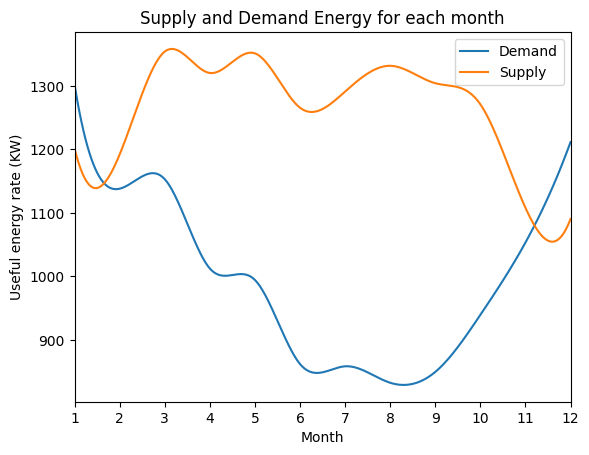

In [45]:
plt.plot(
    interpolate(np.arange(1,13,1), monthly_de)[0],interpolate(np.arange(1,13,1), monthly_de)[1]
)
plt.plot(
    interpolate(np.arange(1,13,1), monthly_s)[0],interpolate(np.arange(1,13,1), monthly_s)[1]
)
plt.xlim([1,12])
plt.xticks(np.arange(1,13,1))
plt.title("Supply and Demand Energy for each month")
plt.xlabel("Month")
plt.ylabel("Useful energy rate (KW)")
plt.legend(["Demand","Supply"])
plt.savefig("Supply and Demand.png")
plt.show()


In [46]:
cond1 = ((interpolate(np.arange(1,13,1), monthly_s)[1]<interpolate(np.arange(1,13,1), monthly_de)[1]) * (interpolate(np.arange(1,13,1), monthly_s)[0]<2))
cond2 = ((interpolate(np.arange(1,13,1), monthly_s)[1]<interpolate(np.arange(1,13,1), monthly_de)[1]) * (interpolate(np.arange(1,13,1), monthly_s)[0]>11))
sup1 = simpson(interpolate(np.arange(1,13,1), monthly_s)[1][cond1], x=interpolate(np.arange(1,13,1), monthly_s)[0][cond1])
dem1 = simpson(interpolate(np.arange(1,13,1), monthly_de)[1][cond1], x=interpolate(np.arange(1,13,1), monthly_de)[0][cond1])
sup2 = simpson(interpolate(np.arange(1,13,1), monthly_s)[1][cond2], x=interpolate(np.arange(1,13,1), monthly_s)[0][cond2])
dem2 = simpson(interpolate(np.arange(1,13,1), monthly_de)[1][cond2], x=interpolate(np.arange(1,13,1), monthly_de)[0][cond2])
shortage = sup1+sup2-dem1-dem2
print("Shortage =", -shortage , "Watt")

Shortage = 94.9688414887031 Watt
